# Chapter 1 : Prompt Chaining

프롬프트 체인, 파이프라인 패턴라고 한다. divide-and-conquer 전략을 주장하는 핵심 아이디어는 문제를 작은, 더 관리하기 쉬운 서브 문제들로 분해하는 것이다. 
각 서브 문제는 특별히 설계된 프롬프트로 개별적으로 처리되고, 한 프롬프트에서 생성된 출력이 다음 프롬프트 입력으로 제공된다.

프롬프트 체이닝의 연속적인 처리는 LLM 고의 상호작용에 모듈화와 명확성을 자연스럽게 도입한다. 복잡한 태스크를 분해함으로써 각 스텝에 대한 이해와 디버깅이 쉬워져서 전체 프로세스가 더 강력하고 해석가능하게 된다.

LLM이 이전 작업을 기반으로 작업을 수행하고, 이해를 재정의하고, 원하는 솔루션에 점진적으로 가까워지게 한다

게다가, 프롬프트 체이닝은 문제 분해 뿐만이 아니라, 외부 지식과 툴과도 통합할 수 있다.

에이전트는 프롬프트 체인으로 자율적으로 계획, 논리적 사고, 행동을 할 수 있어서. 복잡한 AI 에이전트를 구축하는 기본 기술로 활용된다.

## Enhanced Reliability Through Sequential Decomposition
프롬프트 체인으로 복잡한 작업에 대한 신뢰성과 통제력을 향상 시킬 수 있다. 예제로

1. 마켓 리서치 리포트를 요약하는 초기 프롬프트
2. 요약을 사용해서 세가지 트렌드와 각 트렌드를 보조 하는 데이터 포인트 식별
3. 트렌드와 데이터 포인트로 이메일을 작성

제시하는데 특정 단계에 대한 정확한 응답 보장을 위해, 각 단계마다 모델에 역할을 할당 할 수 있다. 

1. 시장 분석가
2. 거래 분석가 
3. 전문 문서 작성자

## The Role of Structured Output
프롬프트 체인에서 한 단계의 출력이 모호하거나 잘못된 형식이면, 다음 프롬프트가 잘못된 입력으로 실패할 수 있기 때문에. 구조화된 출력 형식을 사용이 중요하다

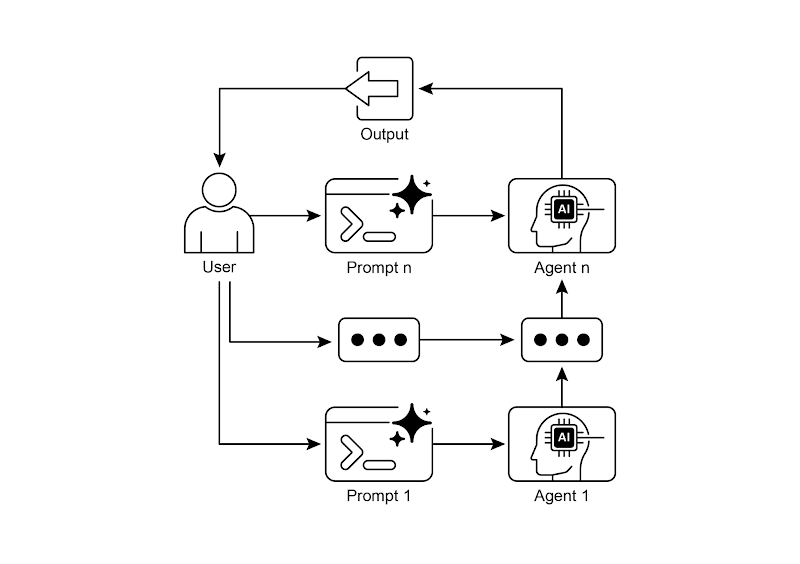

In [1]:
!curl -X POST http://127.0.0.1:8080/v1/chat/completions \
  -H "Content-Type: application/json" \
  -d '{"model":"local","messages":[{"role":"user","content":"Hello"}],"max_tokens":50}'

{"choices":[{"finish_reason":"length","index":0,"message":{"role":"assistant","content":"<think>\nOkay, the user said \"Hello\". I need to respond appropriately. Since they just greeted me, I should acknowledge their greeting. I should keep it friendly and open-ended to encourage further conversation. Maybe say something like \"Hello! How can"}}],"created":1761051605,"model":"local","system_fingerprint":"b6800-0398752d","object":"chat.completion","usage":{"completion_tokens":50,"prompt_tokens":9,"total_tokens":59},"id":"chatcmpl-CUpAnWuzP8XRCUjxNhWq04ob7jubhbhy","__verbose":{"index":0,"content":"<think>\nOkay, the user said \"Hello\". I need to respond appropriately. Since they just greeted me, I should acknowledge their greeting. I should keep it friendly and open-ended to encourage further conversation. Maybe say something like \"Hello! How can","tokens":[],"id_slot":0,"stop":true,"model":"local","tokens_predicted":50,"tokens_evaluated":9,"generation_settings":{"seed":4294967295,"tem

In [10]:
import requests
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END


API_URL = "http://127.0.0.1:8080/v1/chat/completions"

# llama.cpp REST API 호출 함수
def call_llama_api(prompt: str, messages=None, model: str = "qwen3-4b-q4_k_m") -> str:
    if messages is None:
        messages = [
            {"role": "system", "content": "You are a helpful assistant. Answer in Korean. /no_think"},
            {"role": "user", "content": prompt}
        ]

    payload = {
        "model": model,
        "messages": messages,
        "max_tokens": 2048,
        "temperature": 0.7
    }

    resp = requests.post(API_URL, json=payload)
    resp.raise_for_status()
    result = resp.json()

    assistant_message = result['choices'][0]['message']['content']
    if assistant_message.startswith("<think>"):
        assistant_message = assistant_message.split("</think>")[-1].strip()

    return assistant_message

In [3]:
# 상태 타입 정의
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

# 노드 정의
def generate_joke(state: State):
    """첫번 째 노드: 최초의 농담 생성"""
    prompt = f"주제 '{state['topic']}'에 대해 짧고 재미있는 농담을 한-문장으로 작성해 주세요."
    joke = call_llama_api(prompt)
    return {"joke": joke}

def check_punchline(state: State) -> str:
    """분기 노드: 농담의 펀치라인 확인"""
    joke = state["joke"]
    if "?" in joke or "!" in joke:
        return "Pass"
    return "Fail"

def improve_joke(state: State):
    """두번 째 노드: 농담 개선"""
    prompt = f"다음 농담을 더 재미있게 말장난(word-play)을 추가해서 바꿔 주세요: {state['joke']}"
    improved = call_llama_api(prompt)
    return {"improved_joke": improved}

def polish_joke(state: State):
    """세번 째 노드: 최종 마무리"""
    prompt = f"이 농담에 놀라운 반전을 추가해 주세요: {state['improved_joke']}"
    final = call_llama_api(prompt)
    return {"final_joke": final}


# 그래프 생성
workflow = StateGraph(State)

workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

In [4]:
chain = workflow.compile()

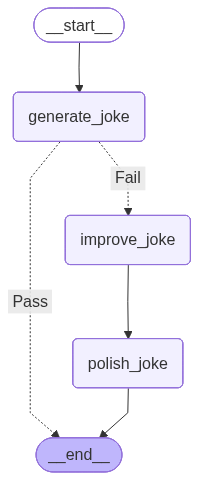

In [5]:
from IPython.display import Image, display

display(Image(chain.get_graph().draw_mermaid_png()))

In [6]:
state = chain.invoke({"topic": "고양이"})

In [7]:
state['joke']

'고양이는 사람을 쫓아다니지만, 결국은 우리를 쫓아다니는 거야.'

In [8]:
state['improved_joke']

'물론입니다! 다음은 농담에 말장난을 추가한 버전입니다:\n\n**"고양이는 사람을 쫓아다니지만, 결국은 우리를 쫓아다니는 거야. 왜냐하면 우리를 쫓아다니면, 우리가 쫓아다니는 거야!"**\n\n이렇게 말하면 고양이의 성격과 인간의 관계를 더욱 재미있고 말장난 있게 표현할 수 있어요! 😄'

In [9]:
state['final_joke']

'물론입니다! 농담에 더 놀라운 반전을 추가해 보겠습니다:\n\n**"고양이는 사람을 쫓아다니지만, 결국은 우리를 쫓아다니는 거야. 왜냐하면 우리를 쫓아다니면, 우리가 쫓아다니는 거야! 그리고 우리가 쫓아다니면, 결국은 고양이가 쫓아다니는 거야!"**\n\n이렇게 말하면 고양이의 성격과 인간의 관계를 더욱 재미있고 말장난 있게, 그리고 조금은 놀라운 반전까지 넣어볼 수 있어요! 😄'

# Chapter 1 (Code)

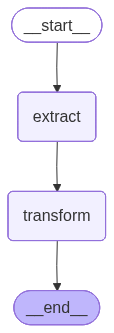

In [ ]:
class State(TypedDict):
    text_input: str
    specifications: str
    json_output: str


def node_extract(state: State):
    prompt = f"다음 텍스트에서 기술 스펙을 추출하세요: {state['text_input']}"
    specs = call_llama_api(prompt)
    return {"specifications": specs}

def node_transform(state: State):
    prompt = f"다음 스펙을 'cpu', 'memory', 'storage' 키를 가지는 JSON 객체로 변환하세요: {state['specifications']}"
    json_out = call_llama_api(prompt)
    return {"json_output": json_out}


workflow = StateGraph(State)
workflow.add_node("extract", node_extract)
workflow.add_node("transform", node_transform)

workflow.set_entry_point("extract")
workflow.add_edge("extract", "transform")
workflow.add_edge("transform", END)

chain = workflow.compile()

display(Image(chain.get_graph().draw_mermaid_png()))

In [13]:
state = chain.invoke({"text_input": "새 노트북 모델은 3.5GHz 옥타코어 프로세서, 16GB RAM, 1TB NVMe SSD를 탑재하고 있습니다."})
state['json_output']

'{\n  "cpu": "3.5GHz 옥타코어 프로세서",\n  "memory": "16GB",\n  "storage": "1TB NVMe SSD"\n}'

In [14]:
state['specifications']

'다음은 제공된 텍스트에서 추출한 기술 스펙입니다:\n\n- **프로세서**: 3.5GHz 옥타코어 프로세서  \n- **RAM**: 16GB  \n- **저장 장치**: 1TB NVMe SSD'

# Context Engineering and Prompt Engineering

모델이 처리할 수 있도록 AI 모델에 제공할 완전한 정보 환경을 설계하고 구축하고, 딜리버리하는 체계적인 방식.

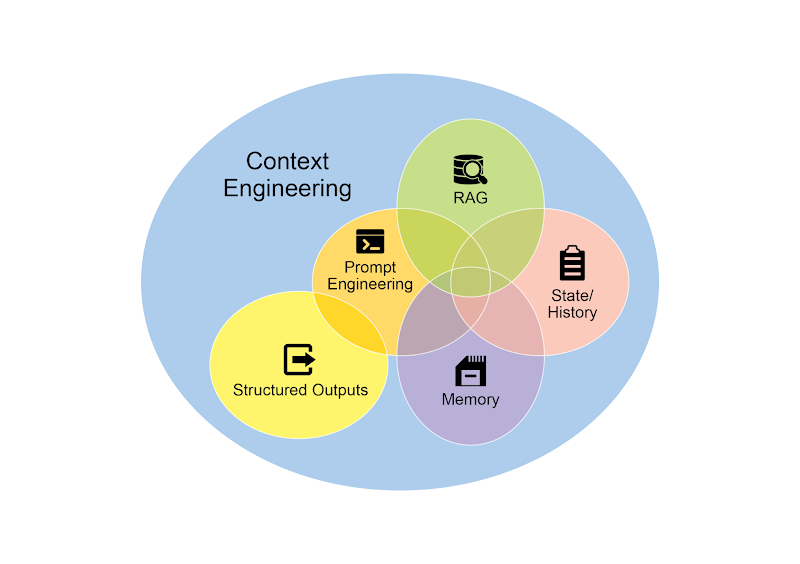

잘 다듬어진 프롬프트 만으로는 상황적 정보나 배경지식이 부족하면 원하는 수준의 응답을 얻기 어려움. 에이전트에 대한 포괄적인 운영 그림을 구축하는 작업
상태가 없는 챗봇을 고도로 유능하고 상황 인식 가능한 시스템으로 발전 시키기 위한 중요한 방법론 ( Vertext AI Prompt Optimizer 같은 튜닝 시스템으로 자동화 할 수 도 있다)